# Определение возраста покупателей

**Описание проекта:** супермаркет внедрить систему компьютерного зрения обработки фотографий покупателей. Это необходимо для анализа покупок и предложения товаров каждой возрастной группе покупателей, а также для контроля добросовестности кассиров при продаже алкоголя. Таким образом, нужно уметь определять примерный возраст покупателя по его фотографии.

**Цель проекта:** построить модель, определяющую по фотографии приблизительный возраст человека.

**Используемые данные:** набор фотографий людей с указанием возраста.

## Оглавление
1. [Исследовательский анализ данных](#1)
2. [Обучение модели](#2)
3. [Анализ полученной модели](#3)

<a id="1"></a>
## 1. Исследовательский анализ данных
Импортируем необходимые для работы библиотеки, считаем csv-файл с данными и выведем часть данных, чтобы убедиться, что всё считалось нормально.

In [1]:
from PIL import Image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/datasets/faces/labels.csv")
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим на размер выборки и построим гистограмму распределения людей из выборки по возрастам.

In [3]:
print("Размер выборки:", data.shape)

Размер выборки: (7591, 2)


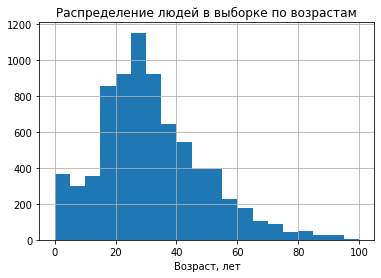

In [4]:
data["real_age"].hist(bins=[i for i in range(0, 101, 5)])
plt.title("Распределение людей в выборке по возрастам")
plt.xlabel("Возраст, лет");

Больше всего людей в возрасте от 20 до 40 лет, при этом те, кто старше 60 лет, представлены в выборке хуже.

Выделим 15 случайных людей и выведем их изображения на экран.

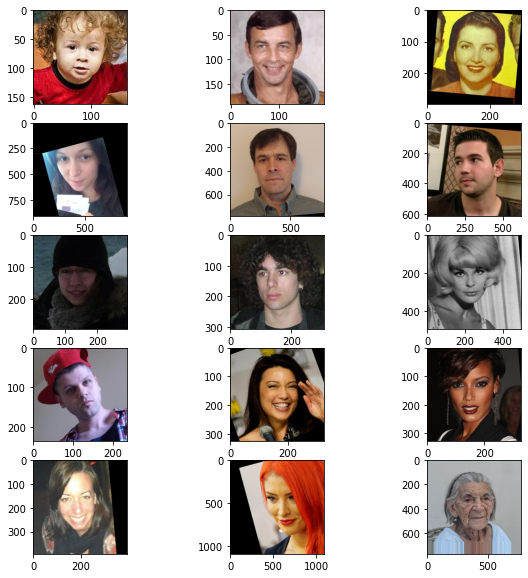

In [5]:
selected_files = data["file_name"].sample(15, random_state=42).values

path_to_photos = "/datasets/faces/final_files/"
fig = plt.figure(figsize=(10, 10))
for i, name in enumerate(selected_files):
    image = Image.open(path_to_photos + name)
    array = np.array(image)
    fig.add_subplot(5, 3, i+1)
    plt.imshow(array)

Изображения разного размера, это нужно учитывать при создании загрузчика данных. Перейдём к обучению модели.

<a id="2"></a>
## 2. Обучение модели
Напишем функции для получения обучающей и тестовой выборок, создания модели и её обучения. Затем отправим написанный код на выполнение на GPU.

***Примечание.*** 
*Этот код был отправлен в виде скрипта на сервер Яндекс.Практикума. Резльтаты его выполнения приведены ниже.*

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + "labels.csv")
    datagen = ImageDataGenerator(rescale=1/255.,
                                 validation_split=0.25)

    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + "/final_files/",
                                                     x_col="file_name",
                                                     y_col="real_age",
                                                     class_mode="raw",
                                                     target_size=(224, 224),
                                                     batch_size=16,
                                                     subset="training",
                                                     seed=42)
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + "labels.csv")
    datagen = ImageDataGenerator(rescale=1/255.,
                                 validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                    directory=path  + "/final_files/",
                                                    x_col="file_name",
                                                    y_col="real_age",
                                                    class_mode="raw",
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    subset="validation",
                                                    seed=42)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights="/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    model.compile(optimizer=Adam(lr=0.0001),
                  loss="mse",
                  metrics=["mae"])

    return model


def train_model(model, 
                train_data, test_data, 
                batch_size=None, epochs=10,
                steps_per_epoch=None, 
                validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)

    return model 

В результате обучения модели и её проверки на тестовой выборке получаем следующее:

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 46s - loss: 204.5099 - mae: 10.4054 - val_loss: 733.1878 - val_mae: 22.0667
Epoch 2/10
356/356 - 37s - loss: 67.7872 - mae: 6.2621 - val_loss: 143.4656 - val_mae: 8.9250
Epoch 3/10
356/356 - 37s - loss: 36.9211 - mae: 4.6959 - val_loss: 74.9071 - val_mae: 6.7681
Epoch 4/10
356/356 - 37s - loss: 24.7769 - mae: 3.8119 - val_loss: 73.4302 - val_mae: 6.4269
Epoch 5/10
356/356 - 38s - loss: 18.1994 - mae: 3.2647 - val_loss: 69.5382 - val_mae: 6.2699
Epoch 6/10
356/356 - 37s - loss: 15.0353 - mae: 2.9694 - val_loss: 65.1733 - val_mae: 6.1326
Epoch 7/10
356/356 - 37s - loss: 12.8334 - mae: 2.7430 - val_loss: 92.2922 - val_mae: 7.2900
Epoch 8/10
356/356 - 37s - loss: 11.6874 - mae: 2.5878 - val_loss: 68.5352 - val_mae: 6.2788
Epoch 9/10
356/356 - 37s - loss: 9.9547 - mae: 2.3950 - val_loss: 67.4254 - val_mae: 6.2149
Epoch 10/10
356/356 - 37s - loss: 8.9540 - mae: 2.2675 - val_loss: 65.1119 - val_mae: 6.0143

119/119 - 9s - loss: 65.1119 - mae: 6.0143
Test MAE: 6.0143
```

<a id="3"></a>
## 3. Анализ обученной модели
В проекте использовалась предобученная модель `ResNet50`, слои при обучении не замораживались. В качестве оптимизатора был выбран `Adam` с шагом обучения (*learning rate*) равным `0.0001`. Аугментация при этом не проводилась.

Построенная модель относительно хорошо справляется с определением возраста человека по фотографии. На тестовой выборке значение MAE составило `6.0143`. 

Качество модели можно попробовать повысить следующими способами:
* провести аугментацию (например, отразить фото зеркально слева направо или закрыть часть лица);
* изменить скорость обучения;
* увеличить значение параметра `target_size`.